In [1]:
%matplotlib inline


.. currentmodule:: dgl

DGLGraph and Node/edge Features
===============================

**Author**: `Minjie Wang <https://jermainewang.github.io/>`_, Quan Gan, Yu Gai,
Zheng Zhang

In this tutorial, you learn how to create a graph and how to read and write node and edge representations.


Creating a graph
----------------
The design of :class:`DGLGraph` was influenced by other graph libraries. You 
can create a graph from networkx and convert it into a :class:`DGLGraph` and 
vice versa.



DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/home/yons/anaconda3/envs/torch/lib/python3.6/site-packages/dgl/base.py:45: DGLWarning: Detected an old version of PyTorch. Suggest using torch>=1.5.0 for the best experience.
  return warnings.warn(message, category=category, stacklevel=1)
/home/yons/anaconda3/envs/torch/lib/python3.6/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


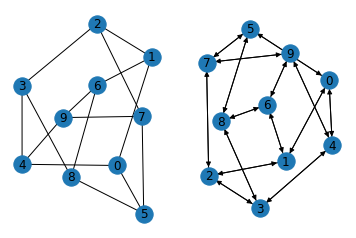

In [2]:
import networkx as nx
import dgl

g_nx = nx.petersen_graph()
g_dgl = dgl.DGLGraph(g_nx)

import matplotlib.pyplot as plt
plt.subplot(121)
nx.draw(g_nx, with_labels=True)
plt.subplot(122)
nx.draw(g_dgl.to_networkx(), with_labels=True)

plt.show()

There are many ways to construct a :class:`DGLGraph`. Below are the allowed
data types ordered by our recommendataion.

* A pair of arrays ``(u, v)`` storing the source and destination nodes respectively.
  They can be numpy arrays or tensor objects from the backend framework.
* ``scipy`` sparse matrix representing the adjacency matrix of the graph to be
  constructed.
* ``networkx`` graph object.
* A list of edges in the form of integer pairs.

The examples below construct the same star graph via different methods.

:class:`DGLGraph` nodes are a consecutive range of integers between 0 and
:func:`number_of_nodes() <DGLGraph.number_of_nodes>`. 
:class:`DGLGraph` edges are in order of their additions. Note that
edges are accessed in much the same way as nodes, with one extra feature:
*edge broadcasting*.



In [3]:
import torch as th
import numpy as np
import scipy.sparse as spp

# Create a star graph from a pair of arrays (using ``numpy.array`` works too).
u = th.tensor([0, 0, 0, 0, 0])
v = th.tensor([1, 2, 3, 4, 5])
star1 = dgl.DGLGraph((u, v))

# Create the same graph in one go! Essentially, if one of the arrays is a scalar,
# the value is automatically broadcasted to match the length of the other array
# -- a feature called *edge broadcasting*.
start2 = dgl.DGLGraph((0, v))

# Create the same graph from a scipy sparse matrix (using ``scipy.sparse.csr_matrix`` works too).
adj = spp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
star3 = dgl.DGLGraph(adj)

/home/yons/anaconda3/envs/torch/lib/python3.6/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


TypeError: object of type 'int' has no len()

You can also create a graph by progressively adding more nodes and edges.
Although it is not as efficient as the above constructors, it is suitable
for applications where the graph cannot be constructed in one shot.



In [4]:
g = dgl.DGLGraph()
g.add_nodes(10)
# A couple edges one-by-one
for i in range(1, 4):
    g.add_edge(i, 0)
# A few more with a paired list
src = list(range(5, 8)); dst = [0]*3
g.add_edges(src, dst)
# finish with a pair of tensors
src = th.tensor([8, 9]); dst = th.tensor([0, 0])
g.add_edges(src, dst)

# Edge broadcasting will do star graph in one go!
g.clear(); g.add_nodes(10)
src = th.tensor(list(range(1, 10)));
g.add_edges(src, 0)

# Visualize the graph.
nx.draw(g.to_networkx(), with_labels=True)
plt.show()

/home/yons/anaconda3/envs/torch/lib/python3.6/site-packages/dgl/base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)
/home/yons/anaconda3/envs/torch/lib/python3.6/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.add_edge is deprecated. Please use DGLGraph.add_edges
  return warnings.warn(message, category=category, stacklevel=1)


AttributeError: 'DGLHeteroGraph' object has no attribute 'clear'

Assigning a feature
-------------------
You can also assign features to nodes and edges of a :class:`DGLGraph`.  The
features are represented as dictionary of names (strings) and tensors,
called **fields**.

The following code snippet assigns each node a vector (len=3).

<div class="alert alert-info"><h4>Note</h4><p>DGL aims to be framework-agnostic, and currently it supports PyTorch and
   MXNet tensors. The following examples use PyTorch only.</p></div>



In [ ]:
import dgl
import torch as th

x = th.randn(10, 3)
g.ndata['x'] = x

:func:`ndata <DGLGraph.ndata>` is a syntax sugar to access the feature
data of all nodes. To get the features of some particular nodes, slice out
the corresponding rows.



In [ ]:
g.ndata['x'][0] = th.zeros(1, 3)
g.ndata['x'][[0, 1, 2]] = th.zeros(3, 3)
g.ndata['x'][th.tensor([0, 1, 2])] = th.randn((3, 3))

Assigning edge features is similar to that of node features,
except that you can also do it by specifying endpoints of the edges.



In [ ]:
g.edata['w'] = th.randn(9, 2)

# Access edge set with IDs in integer, list, or integer tensor
g.edata['w'][1] = th.randn(1, 2)
g.edata['w'][[0, 1, 2]] = th.zeros(3, 2)
g.edata['w'][th.tensor([0, 1, 2])] = th.zeros(3, 2)

# You can get the edge ids by giving endpoints, which are useful for accessing the features.
g.edata['w'][g.edge_id(1, 0)] = th.ones(1, 2)                   # edge 1 -> 0
g.edata['w'][g.edge_ids([1, 2, 3], [0, 0, 0])] = th.ones(3, 2)  # edges [1, 2, 3] -> 0
# Use edge broadcasting whenever applicable.
g.edata['w'][g.edge_ids([1, 2, 3], 0)] = th.ones(3, 2)          # edges [1, 2, 3] -> 0

After assignments, each node or edge field will be associated with a scheme
containing the shape and data type (dtype) of its field value.



In [ ]:
print(g.node_attr_schemes())
g.ndata['x'] = th.zeros((10, 4))
print(g.node_attr_schemes())

You can also remove node or edge states from the graph. This is particularly
useful to save memory during inference.



In [ ]:
g.ndata.pop('x')
g.edata.pop('w')

Working with multigraphs
~~~~~~~~~~~~~~~~~~~~~~~~
Many graph applications need parallel edges,
which class:DGLGraph supports by default.



In [ ]:
g_multi = dgl.DGLGraph()
g_multi.add_nodes(10)
g_multi.ndata['x'] = th.randn(10, 2)

g_multi.add_edges(list(range(1, 10)), 0)
g_multi.add_edge(1, 0) # two edges on 1->0

g_multi.edata['w'] = th.randn(10, 2)
g_multi.edges[1].data['w'] = th.zeros(1, 2)
print(g_multi.edges())

An edge in multigraph cannot be uniquely identified by using its incident nodes
$u$ and $v$; query their edge IDs use ``edge_id`` interface.



In [ ]:
eid_10 = g_multi.edge_id(1, 0, return_array=True)
g_multi.edges[eid_10].data['w'] = th.ones(len(eid_10), 2)
print(g_multi.edata['w'])

<div class="alert alert-info"><h4>Note</h4><p>* Nodes and edges can be added but not removed.
   * Updating a feature of different schemes raises the risk of error on individual nodes (or
     node subset).</p></div>



Next steps
----------
In the :doc:`next tutorial <3_pagerank>` you learn the
DGL message passing interface by implementing PageRank.

